![Spark Logo](http://spark-mooc.github.io/web-assets/images/ta_Spark-logo-small.png)  ![Python Logo](http://spark-mooc.github.io/web-assets/images/python-logo-master-v3-TM-flattened_small.png)
# PEC M3 Dataframes: Noviembre 2023

## Extracción de conocimiento de fuentes de datos heterogéneas mediante Spark SQL, RDDs

En esta PEC introduciremos estructuras de datos más complejas que las vistas hasta ahora, donde los campos pueden tener otros campos anidados. Utilizaremos los datos de IMDB (https://www.imdb.com/) sobre películas. Específicamente utilizaremos unos archivos sobre 'reviews' de películas realizados por un conjunto de usuarios y sobre estos archivos realizaremos una serie de operaciones mediante SparkSQL y Dataframes.

Realizaremos un conjunto de preguntas sobre los archivos que puede ir respondiendo de forma secuencial.<br>
A lo largo del ejercicio veréis espacios con:
````
<FILL_IN>
````
Debéis completar estos espacios con los contenidos que se piden.





## 1. Inicialización del entorno y carga de archivos (2 puntos)

Es necesario cargar el entorno de trabajo inicializando SparkContext.

In [2]:
import findspark
findspark.init()
import pyspark
import random
sc = pyspark.SparkContext(master="local[1]", appName="PAC1_emadariagal")

In [3]:
from pyspark import SparkConf, SparkContext, SQLContext, HiveContext
from pyspark.sql import Row

In [4]:
sqlContext = SQLContext(sc)

### 1.1 Carga de archivos en HDFS

Los archivos se encuentran en el sistema de archivos local de la máquina. Los debéis cargar en HDFS.

Son dos archivos:
* Un archivo con datos maestro sobre las películas: **IMDB_movie_details.json**
* Un archivos con las reviews de las películas: **IMDB_reviews.json**

Los archivos se encuentran 22.519/data

Cárguelos mediante los comandos trabajados en la primera PAC en el sistema HDFS. Utilizad una ubicación en su espacio en HDFS.


In [6]:
!hdfs dfs -ls 

Found 11 items
drwx------   - emadariagal emadariagal          0 2023-11-27 14:00 .Trash
drwx------   - emadariagal emadariagal          0 2023-10-29 19:18 .staging
drwxr-xr-x   - emadariagal emadariagal          0 2023-10-29 14:49 d_pais
drwxr-xr-x   - emadariagal emadariagal          0 2023-10-29 18:56 d_tipo_habitacion
drwxr-xr-x   - emadariagal emadariagal          0 2023-10-29 20:13 data
drwxr-xr-x   - emadariagal emadariagal          0 2023-10-29 19:18 h_reserva
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-17 11:45 json_data
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 13:27 movie_details
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 13:34 movie_details_particiones
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 13:53 movie_reviews
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 15:29 movie_reviews_particiones


In [7]:
# Crear directorio en /user/emadariagal/json_data para almacenar los ficheros json
!hdfs dfs -mkdir /user/emadariagal/json_data

mkdir: `/user/emadariagal/json_data': File exists


In [8]:
# subir un fichero de mi maquina a Hdfs
!hdfs dfs -put /22.519/data/IMDB_movie_details.json /user/emadariagal/json_data
!hdfs dfs -put /22.519/data/IMDB_reviews.json /user/emadariagal/json_data

put: `/user/emadariagal/json_data/IMDB_movie_details.json': File exists
put: `/user/emadariagal/json_data/IMDB_reviews.json': File exists


Verificad que los archivos se encuentran en la ubicación que habéis seleccionado:

In [9]:
# Listar directorio para comprobar que se ha subido el fichero a la ruta destino.
!hdfs dfs -ls json_data

Found 2 items
-rw-r--r--   3 emadariagal emadariagal   14182324 2023-11-17 11:45 json_data/IMDB_movie_details.json
-rw-r--r--   3 emadariagal emadariagal  952594008 2023-11-17 11:45 json_data/IMDB_reviews.json


Mediante el comando hdfs fsck verificad el número de bloques de cada archivo para entender cómo HDFS lo ha cargado:

In [10]:
# -files -blocks Print out the block report (obtener el número de bloques de cada archivo)
!hdfs fsck /user/emadariagal/json_data/IMDB_reviews.json -files -blocks

Connecting to namenode via http://eimtcld2.uoclabs.uoc.es:9870/fsck?ugi=emadariagal&files=1&blocks=1&path=%2Fuser%2Femadariagal%2Fjson_data%2FIMDB_reviews.json
FSCK started by emadariagal (auth:SIMPLE) from /213.73.35.120 for path /user/emadariagal/json_data/IMDB_reviews.json at Mon Nov 27 18:14:16 CET 2023
/user/emadariagal/json_data/IMDB_reviews.json 952594008 bytes, replicated: replication=3, 8 block(s):  OK
0. BP-2074018746-213.73.35.119-1563889676427:blk_1109493098_35767302 len=134217728 Live_repl=3
1. BP-2074018746-213.73.35.119-1563889676427:blk_1109493099_35767303 len=134217728 Live_repl=3
2. BP-2074018746-213.73.35.119-1563889676427:blk_1109493100_35767304 len=134217728 Live_repl=3
3. BP-2074018746-213.73.35.119-1563889676427:blk_1109493101_35767305 len=134217728 Live_repl=3
4. BP-2074018746-213.73.35.119-1563889676427:blk_1109493102_35767306 len=134217728 Live_repl=3
5. BP-2074018746-213.73.35.119-1563889676427:blk_1109493103_35767307 len=134217728 Live_repl=3
6. BP-207401874

In [11]:
# -files -blocks Print out the block report (obtener el número de bloques de cada archivo)
!hdfs fsck /user/emadariagal/json_data/IMDB_movie_details.json -files -blocks 

Connecting to namenode via http://eimtcld2.uoclabs.uoc.es:9870/fsck?ugi=emadariagal&files=1&blocks=1&path=%2Fuser%2Femadariagal%2Fjson_data%2FIMDB_movie_details.json
FSCK started by emadariagal (auth:SIMPLE) from /213.73.35.120 for path /user/emadariagal/json_data/IMDB_movie_details.json at Mon Nov 27 18:14:18 CET 2023
/user/emadariagal/json_data/IMDB_movie_details.json 14182324 bytes, replicated: replication=3, 1 block(s):  OK
0. BP-2074018746-213.73.35.119-1563889676427:blk_1109493097_35767301 len=14182324 Live_repl=3


Status: HEALTHY
 Number of data-nodes:	3
 Number of racks:		1
 Total dirs:			0
 Total symlinks:		0

Replicated Blocks:
 Total size:	14182324 B
 Total files:	1
 Total blocks (validated):	1 (avg. block size 14182324 B)
 Minimally replicated blocks:	1 (100.0 %)
 Over-replicated blocks:	0 (0.0 %)
 Under-replicated blocks:	0 (0.0 %)
 Mis-replicated blocks:		0 (0.0 %)
 Default replication factor:	3
 Average block replication:	3.0
 Missing blocks:		0
 Corrupt blocks:		0
 Mis

Cuantos bloques hay para cada fichero?

**Se observa:**
* El fichero IMDB_reviews.json esta partido en 8 bloques HDFS.
* El fichero IMDB_movie_details.json en un único bloque HDFS.

### 1.2 Carga de los archivos en Spark y exploración
Una vez que los archivos ya están en HDFS, se realizará la carga en Spark para su exploración:

In [12]:
movie_details = sqlContext.read.json("json_data/IMDB_movie_details.json")

In [13]:
print(type(movie_details))

<class 'pyspark.sql.dataframe.DataFrame'>


Utilizaremos el comando que Spark nos ofrece para conocer el número de particiones de cada uno de los dataframes.

In [14]:
movie_details.rdd.getNumPartitions()

1

Repetimos el proceso para el fichero de reviews:

In [15]:
movie_reviews = sqlContext.read.json("json_data/IMDB_reviews.json")

Consultad el número de particiones del dataframe cargado:

In [16]:
movie_reviews.rdd.getNumPartitions()

8

¿Cuántas particiones hay por cada dataframe? ¿Qué relación tienen con lo que has observado al explorarlos en HDFS?

**Respuesta:** El Dataframe 'movie_details' tiene una unica particion y 'movie_reviews' tiene 8.Se observa que en este caso, que los dataframes generados con la funcion  sqlContext.read.json de la API de SparkSQL tienen las mismas particiones que las particiones realizadas al subir los ficheros de nuestra maquina local a nuestro espacio HDFS.

Una vez cargados los archivos, vamos a explorarlos:

¿Qué tipo de objeto son movie_details y movie_reviews?

In [17]:
print(type(movie_details))
print(type(movie_reviews))

<class 'pyspark.sql.dataframe.DataFrame'>
<class 'pyspark.sql.dataframe.DataFrame'>


**Respuesta:** <class 'pyspark.sql.dataframe.DataFrame'> nos dice que  es un objeto de tipo Dataframe en la biblioteca de PySpark. PySpark SQL es un modulo que ofrece PySpark para trabajar con datos estructurados utilizando el lenguaje SQL. Un DataFrame es una colección distribuida inmutable de datos estructurados.

Convierte el dataframe movie_details a un rdd, selecciona el primer registro y explica cuál es el resultado:

In [18]:
movie_details.rdd.first()

Row(duration='1h 57min', genre=['Action', 'Thriller'], movie_id='tt0105112', plot_summary="Former CIA analyst, Jack Ryan is in England with his family on vacation when he suddenly witnesses an explosion outside Buckingham Palace. It is revealed that some people are trying to abduct a member of the Royal Family but Jack intervenes, killing one of them and capturing the other, and stops the plan in its tracks. Afterwards, he learns that they're Irish revolutionaries and the two men are brothers. During his court hearing the one that's still alive vows to get back at Jack but is sentenced and that seems to be the end of it. However, whilst the man is being transported, he is broken out. Jack learns of this but doesn't think there's anything to worry about. But, when he is at the Naval Academy someone tries to kill him. He learns that they are also going after his family and so he rushes to find them, safe but having also been the victims of a failed assassination. That's when Jack decides

In [19]:
#¿Qué has observado al ejecutar el pedido anterior? 

**Respuesta**: con el comando .first() nos muestra el primer registro del RDD. Se puede ver distintos campos (duration, genre,movie_id, plot_summary, plot_synopsis, rating, release_date). En definitiva son campos que recopilan información detallada de cada pelicula( tiempo de duracion, genero, su id, resumen detallado de la pelicula , breve resumen de la trama sobre pelicula, puntuación y fecha de lanzamiento. Si hacemos un movie_details.show() podemos visualizar de forma estructurada  y mucho mejor los datos almacenados el DataFrame. En el RDD vemos un texto muy compacto en el que conforme vas adentrandote encontrar a golpe de vista los campos es más costoso.

In [20]:
movie_details.show(1)

+--------+------------------+---------+--------------------+--------------------+------+------------+
|duration|             genre| movie_id|        plot_summary|       plot_synopsis|rating|release_date|
+--------+------------------+---------+--------------------+--------------------+------+------------+
|1h 57min|[Action, Thriller]|tt0105112|Former CIA analys...|Jack Ryan (Ford) ...|   6.9|  1992-06-05|
+--------+------------------+---------+--------------------+--------------------+------+------------+
only showing top 1 row



Una vez hecho un primer análisis de lo que hemos cargado, vamos a ver su contenido. Mediante el comando show(), exploramos los primeros 10 registros del dataframe.

In [21]:
movie_reviews.show(10)

+----------+---------+------+----------------+--------------------+--------------------+----------+
|is_spoiler| movie_id|rating|     review_date|      review_summary|         review_text|   user_id|
+----------+---------+------+----------------+--------------------+--------------------+----------+
|      true|tt0111161|    10|10 February 2006|A classic piece o...|In its Oscar year...| ur1898687|
|      true|tt0111161|    10|6 September 2000|Simply amazing. T...|The Shawshank Red...| ur0842118|
|      true|tt0111161|     8|   3 August 2001|The best story ev...|I believe that th...| ur1285640|
|      true|tt0111161|    10|1 September 2002|Busy dying or bus...|**Yes, there are ...| ur1003471|
|      true|tt0111161|     8|     20 May 2004|Great story, wond...|At the heart of t...| ur0226855|
|      true|tt0111161|     8|  12 August 2004|Good , But It Is ...|In recent years t...| ur1532177|
|      true|tt0111161|     9|  9 October 2005|This Movie Saved ...|I have been a fan...| ur6574726|


Como puede verse, el comando _show()_ nos _trunca_ el contenido en aquellas variables textuales demasiado largas. Ahora utilice el mismo comando para mostrar los 10 primeros registros pero sin _truncar_ su contenido

In [22]:
movie_reviews.show(10, truncate=False)

+----------+---------+------+----------------+-----------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [23]:
movie_reviews.show(10, truncate=60)

+----------+---------+------+----------------+------------------------------------------------------------+------------------------------------------------------------+----------+
|is_spoiler| movie_id|rating|     review_date|                                              review_summary|                                                 review_text|   user_id|
+----------+---------+------+----------------+------------------------------------------------------------+------------------------------------------------------------+----------+
|      true|tt0111161|    10|10 February 2006|               A classic piece of unforgettable film-making.|In its Oscar year, Shawshank Redemption (written and dire...| ur1898687|
|      true|tt0111161|    10|6 September 2000|                  Simply amazing. The best film of the 90's.|The Shawshank Redemption is without a doubt one of the mo...| ur0842118|
|      true|tt0111161|     8|   3 August 2001|                            The best story ever told o

Comentad, ¿os ha sido útil este comando?

**Respuesta**: Si y no; En la  documentación se menciona que cuando usamos la funcion show() el parametro truncate trunca las cadenas de más de 20 caracteres de forma predeterminada. 
El parametro truncate admite valores de tipo booleano **True**(Trunca las cadenas de más de 20 caracteres); **False**( No trunca nada, en este caso, si te pemite acceder al texto completo pero ocupa mucho en pantalla, mucho scroll hacia abajo si en vez de 10 filas mostramos 50) o valores de tipo **int**, para este caso puede ser el más util, porque te permite truncar las cadenas largas a la longitud del valor entero introducido, lo que ayuda a visualizar un poquito más de texto sin perder la estructura de DataFrame.

Mostrad cuál es el esquema de cada uno de los dataframes:


In [24]:
movie_details.printSchema()

root
 |-- duration: string (nullable = true)
 |-- genre: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- movie_id: string (nullable = true)
 |-- plot_summary: string (nullable = true)
 |-- plot_synopsis: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- release_date: string (nullable = true)



In [25]:
movie_reviews.printSchema()

root
 |-- is_spoiler: boolean (nullable = true)
 |-- movie_id: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- review_date: string (nullable = true)
 |-- review_summary: string (nullable = true)
 |-- review_text: string (nullable = true)
 |-- user_id: string (nullable = true)



### 1.3 Particionado
Hemos subido los archivos a HDFS, pero no hemos controlado las particiones en las que HDFS los ha cargado, como hemos visto anteriormente. Habitualmente nos interesa optimizar las particiones de nuestros datasets para una mejor eficiencia a la hora de realizar consultas y trabajar con ellas.
Analizaremos dos estrategias de particionamiento distintas:
* Reparticionamos los dos dataframes en un número de particiones determinado (4, por ejemplo)
* Reparticionamos mediante un campo de particionamiento del dataframe determinado. Para el dataframe de movie_details, particionaremos por el campo movid_id. Para el dataframe de movie_reviews, particionaremos por review_date.<br>

Guardamos los dataframes resultantes en una ubicación de HDFS que os vaya bien. Es importante que podàis ir explorando el directorio HDFS de trabajo en el que se vayan guardando los resultados. Utilizad la experiencia de la primera PEC.




In [33]:
# Reparticionamiento mediante un campo de particionamiento del dataframe.
# Formato de salida 'json', particinamiento de dataframe por la columna movie_id
movie_details.write.format('json').partitionBy('movie_id').save('/user/emadariagal/movie_details')

In [34]:
# Formato de salida 'json'.Reparticionamiento del dataframe en 4 particiones.
movie_details.repartition(4).write.format('json').save("/user/emadariagal/movie_details_particiones")

In [35]:
# Reparticionamiento mediante un campo de particionamiento del dataframe.
# Formato de salida 'json', particinamiento de dataframe por la columna movie_id
movie_reviews.write.format('json').partitionBy('review_date').save('/user/emadariagal/movie_reviews')

In [36]:
# Formato de salida 'json'.Reparticionamiento del dataframe en 4 particiones.
movie_reviews.repartition(4).write.format('json').save('/user/emadariagal/movie_reviews_particiones') 

Volveremos a explorar el sistema HDFS para ver cuál ha sido la salida en cada caso. Utilizad la siguiente celda o añadid otra para poder mostrar la salida en cada caso.
Se presentan 4 celdas para que podáis explorar cada caso.

In [37]:
!hdfs dfs -ls movie_details 

Found 1571 items
-rw-r--r--   3 emadariagal emadariagal          0 2023-11-27 18:18 movie_details/_SUCCESS
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0012349
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0015864
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0017136
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0017925
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0018455
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0019254
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0021749
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0022100
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:18 movie_details/movie_id=tt0

In [38]:
!hdfs dfs -ls movie_details_particiones

Found 5 items
-rw-r--r--   3 emadariagal emadariagal          0 2023-11-27 18:19 movie_details_particiones/_SUCCESS
-rw-r--r--   3 emadariagal emadariagal    3598049 2023-11-27 18:19 movie_details_particiones/part-00000-be57f168-6351-4d72-9f61-21c734d18c3a-c000.json
-rw-r--r--   3 emadariagal emadariagal    3448420 2023-11-27 18:19 movie_details_particiones/part-00001-be57f168-6351-4d72-9f61-21c734d18c3a-c000.json
-rw-r--r--   3 emadariagal emadariagal    3512848 2023-11-27 18:19 movie_details_particiones/part-00002-be57f168-6351-4d72-9f61-21c734d18c3a-c000.json
-rw-r--r--   3 emadariagal emadariagal    3593174 2023-11-27 18:19 movie_details_particiones/part-00003-be57f168-6351-4d72-9f61-21c734d18c3a-c000.json


In [39]:
!hdfs dfs -ls movie_reviews

Found 7105 items
-rw-r--r--   3 emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/_SUCCESS
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:34 movie_reviews/review_date=1 April 1999
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2000
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2001
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2002
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2003
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2004
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2005
drwxr-xr-x   - emadariagal emadariagal          0 2023-11-27 18:36 movie_reviews/review_date=1 April 2006
drwxr-xr-x   - emadariagal emadariagal       

In [40]:
!hdfs dfs -ls movie_reviews_particiones

Found 5 items
-rw-r--r--   3 emadariagal emadariagal          0 2023-11-27 18:38 movie_reviews_particiones/_SUCCESS
-rw-r--r--   3 emadariagal emadariagal  236266182 2023-11-27 18:38 movie_reviews_particiones/part-00000-0af33457-05ce-4885-822d-846ede01a0d6-c000.json
-rw-r--r--   3 emadariagal emadariagal  235770827 2023-11-27 18:38 movie_reviews_particiones/part-00001-0af33457-05ce-4885-822d-846ede01a0d6-c000.json
-rw-r--r--   3 emadariagal emadariagal  235751558 2023-11-27 18:38 movie_reviews_particiones/part-00002-0af33457-05ce-4885-822d-846ede01a0d6-c000.json
-rw-r--r--   3 emadariagal emadariagal  236169289 2023-11-27 18:38 movie_reviews_particiones/part-00003-0af33457-05ce-4885-822d-846ede01a0d6-c000.json


Analizamos los resultados:

* ¿Creéis que tiene sentido particionar por movie_id el dataframe movie_details?
* ¿Y el dataframe reviews por la fecha?

**Respuesta:**
La particion del dataframe movie_details por el campo movie_id implica que se generen 1571 particiones. Con respecto al dataframe particionado por el campo rewiew_date implica generar 7105 particiones. Las particiones en los datos puede mejorar el rendimiento de las consultas sobre los datos,  sin ebargo,  generar tantas particiones puede ser contraproducente tanto para el rendimiento como a la distribución de los datos o la gestion de recursos. En definitiva, no tiene sentido generar tantas particiones, lo mejor es encontrar un número de particiones que permita un equilibrio entre rendimiento, distribucion y gestion de recursos.


## 2. Análisis de los datos
Seguidamente realizaremos un primer análisis más detallado de los archivos.
Volved a cargar los archivos de la ubicación utilizada en 1.3, la que os parezca más eficiente  (4 particiones o particionamiento por campos).

In [5]:
movie_details = sqlContext.read.json("/user/emadariagal/movie_details_particiones")

In [6]:
movie_details.show(2)

+--------+--------------------+---------+--------------------+--------------------+------+------------+
|duration|               genre| movie_id|        plot_summary|       plot_synopsis|rating|release_date|
+--------+--------------------+---------+--------------------+--------------------+------+------------+
| 2h 1min|  [Biography, Drama]|tt0099077|1969. Dr. Malcolm...|In 1969, Dr. Malc...|   7.8|  1991-01-11|
|2h 12min|[Action, Crime, T...|tt0455944|In The Equalizer,...|Robert McCall (De...|   7.2|  2014-09-26|
+--------+--------------------+---------+--------------------+--------------------+------+------------+
only showing top 2 rows



In [7]:
movie_reviews = sqlContext.read.json("/user/emadariagal/movie_reviews_particiones")     

In [8]:
movie_reviews.show(2)

+----------+---------+------+--------------+--------------------+--------------------+----------+
|is_spoiler| movie_id|rating|   review_date|      review_summary|         review_text|   user_id|
+----------+---------+------+--------------+--------------------+--------------------+----------+
|     false|tt0993846|     5|8 January 2014|Wolf of Wall Stre...|The Wolf of Wall ...|ur17085286|
|     false|tt0167404|     3|14 August 1999|Boring with a pre...|Before seeing thi...| ur0282862|
+----------+---------+------+--------------+--------------------+--------------------+----------+
only showing top 2 rows



### 2.1 Consultas mediante sql
Spark nos permite realizar consultas sql sobre dataframes que, previamente, hemos tenido que guardar como tablas. Así pues, registraremos el dataframe de movie_details como tabla y realizamos algunas consultas básicas. <br>


Regsitrad el dataframe como tabla temporal:

In [9]:
#Utiulitzeu un nom de taula que desitjeu.
movie_details.registerTempTable( "tb_movie_details" )

Muchas veces los datos con los que queremos trabajar se utilizarán en varios proyectos. Una forma de organizar los datos es, en el lugar de utilizar directamente las fichas, hacer uso de una base de datos para gestionar la información, esto es, los metadatos de los dataframes. De modo que ya tenemos la estructura almacenada. En el entorno Hadoop, una de las bases de datos más extendidas es Apache Hive, una base de datos que permite trabajar con contenido distribuido.

La forma de acceder a esta base de datos se realiza creando un contexto Hive de forma muy similar a como declaramos un contexto SQL. Ante todo declaramos una variable hiveContext instanciando como un objeto de la clase HiveContext. Seguidamente se comprueba cuántas tablas están registradas en este contexto. Como vemos, la tabla que acabamos de almacenar queda registrada de forma temporal, mente que tenemos otras tablas registradas de forma no temporal.

In [10]:
hiveContext = HiveContext(sc)
hiveContext.tables().show()

+--------+-----------------+-----------+
|database|        tableName|isTemporary|
+--------+-----------------+-----------+
| default|               as|      false|
| default|        mistweets|      false|
| default|     province_28a|      false|
| default|province_28a_vext|      false|
| default|              src|      false|
| default|        tweets28a|      false|
| default|   tweets28a_vext|      false|
| default|        user_info|      false|
| default|   user_info_vext|      false|
|        | tb_movie_details|       true|
+--------+-----------------+-----------+



A modo de ejemplo, se pide que completéis la siguiente consulta para que nos muestre las películas con un rating superior o igual a 8 y ordenadas en orden descendente:

In [14]:
details_rating_high8 = hiveContext.sql("""  SELECT *
                                    FROM tb_movie_details
                                    where rating >= 8.0
                                    order by rating DESC""")

In [15]:
details_rating_high8.show()

+--------+--------------------+---------+--------------------+--------------------+------+------------+
|duration|               genre| movie_id|        plot_summary|       plot_synopsis|rating|release_date|
+--------+--------------------+---------+--------------------+--------------------+------+------------+
|2h 10min|             [Drama]|tt5867800|A gentle girl bor...|                    |   9.5|  2017-12-15|
|2h 22min|      [Crime, Drama]|tt0111161|Chronicles the ex...|In 1947, Andy Duf...|   9.3|  1994-10-14|
|2h 55min|      [Crime, Drama]|tt0068646|When the aging he...|In late summer 19...|   9.2|  1972-03-24|
|1h 28min|[Crime, Drama, My...|tt1475582|In this modernize...|Series 1Wounded A...|   9.2|  2010-07-27|
|3h 22min|      [Crime, Drama]|tt0071562|The continuing sa...|The Godfather Par...|   9.0|  1974-12-20|
|   51min|[Drama, Fantasy, ...|tt4574334|In a small town w...|It is November 16...|   9.0|  2017-10-27|
|   55min|[Crime, Drama, My...|tt2356777|In 2012, Louisian...|Th

¿Cuantas hay?

In [16]:
details_rating_high8.count()

325

Seguidamente, realizaremos una consulta más complicada.<br>
Complete la siguiente celda para que la consulta agrupe el número de películas por rating. Es decir, ¿cuántas películas tienen el mismo rating? Esto nos permitirá tener una distribución del número de películas por valoración.

In [17]:
details_rating_grouped = hiveContext.sql("""  SELECT rating, count(*) as count
                                    FROM tb_movie_details
                                    group by rating
                                    order by rating asc""")

In [18]:
details_rating_grouped.show()

+------+-----+
|rating|count|
+------+-----+
|   2.4|    1|
|   2.8|    1|
|   3.3|    1|
|   3.6|    1|
|   3.7|    1|
|   3.8|    2|
|   4.0|    1|
|   4.1|    1|
|   4.2|    2|
|   4.3|    4|
|   4.4|    4|
|   4.5|    1|
|   4.6|    2|
|   4.7|    5|
|   4.8|    3|
|   4.9|    4|
|   5.0|    3|
|   5.1|    9|
|   5.2|    9|
|   5.3|   15|
+------+-----+
only showing top 20 rows



¿Cuál es la nota que más aparece?

In [19]:
max_rating = hiveContext.sql("""  SELECT rating, count(*) as count
                                    FROM tb_movie_details
                                    group by rating
                                    order by count DESC
                                    limit 1""")

In [20]:
max_rating.show()

+------+-----+
|rating|count|
+------+-----+
|   8.1|   75|
+------+-----+



Y para completar esta parte del ejercicio, completad la siguiente celda que debe permitirnos representar visualmente la distribución de ratings en la muestra de películas de la que disponemos.

In [21]:
rating_count_pd = details_rating_grouped.toPandas()
rating_count_pd.head()

,rating,count
0,2.4,1
1,2.8,1
2,3.3,1
3,3.6,1
4,3.7,1


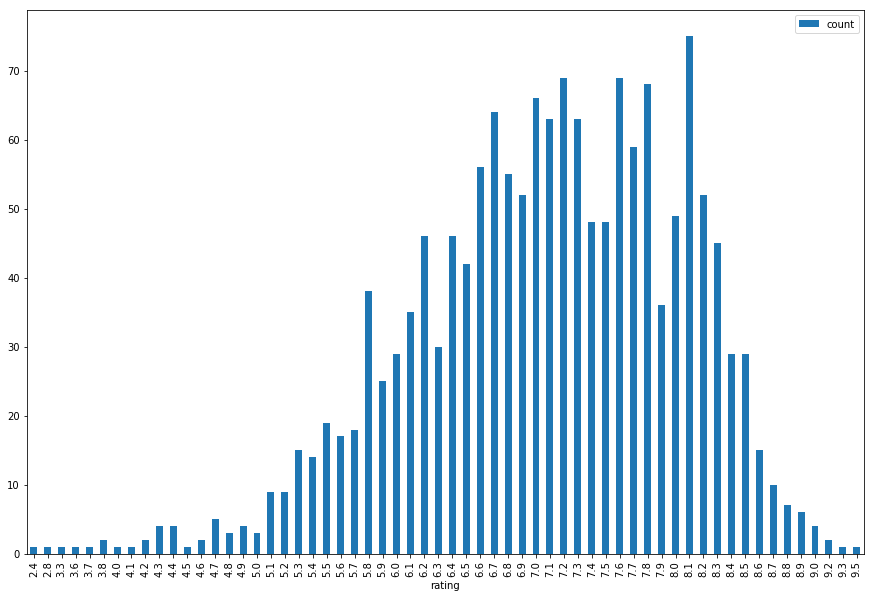

In [24]:
rating_count_pd.plot.bar(x='rating', y='count', figsize=(15, 10)) 

#### 2.2 Analizando el dataset con Spark SQL (6 punts)


Spark SQL ofrece otro mecanismo para aplicar las transformaciones y obtener resultados similares a los que se obtendría aplicando una consulta SQL como se ha practicado en el ejercicio anterior, mediante la API SparkSQL. Podéis consultar [API de spark SQL](https://spark.apache.org/docs/latest/sql-programming-guide.html) donde se puede encontrar más información sobre cómo utilizar las diferentes transformaciones sobre tablas.


Por ejemplo, la siguiente consulta nos permite obtener todas las películas que tienen una nota superior o igual a 8 tal y como se ha hecho en el ejercicio anterior sin usar una consulta sql literal:
````
movie_details.where("rating>=8").select("movie_id, rating")
````

A continuación uno planteamos unos ejercicios para que utilice la API SparkSQL, una de las más utilizadas actualmente en el mundo de la ingeniería de datos.
Los ejercicios que se plantean son muy típicos de un proyecto de definición de indicadores, por ejemplo. En este caso, son una serie de indicadores relativos a la actividad de los usuarios y su valoración de las películas.

Podéis utilizar las transformaciones "where", "select" (o "selectExpr"), "groupBy", "count", "agg" y "orderBy".

##### 2.2.1 ¿Cuál es el usuario que ha escrito más reviews? ¿Y el que ha escrito menos (en caso de que haya más de uno indica cuántos hay)?

A continuación se pide que encontréis el usuario que ha escrito más reviews:

In [26]:
movie_reviews.show(3)

+----------+---------+------+--------------+--------------------+--------------------+----------+
|is_spoiler| movie_id|rating|   review_date|      review_summary|         review_text|   user_id|
+----------+---------+------+--------------+--------------------+--------------------+----------+
|     false|tt0993846|     5|8 January 2014|Wolf of Wall Stre...|The Wolf of Wall ...|ur17085286|
|     false|tt0167404|     3|14 August 1999|Boring with a pre...|Before seeing thi...| ur0282862|
|      true|tt0468569|    10|  21 July 2008|Best example of a...|In most 'Super He...| ur2695250|
+----------+---------+------+--------------+--------------------+--------------------+----------+
only showing top 3 rows



In [27]:
movie_reviews.count() # Total de filas del DataFrame.

573913

In [28]:
movie_reviews.groupBy('user_id').agg({"movie_id":"count"}).orderBy("count(movie_id)", ascending=False).show(10)

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
| ur2898520|           1303|
| ur4248714|           1021|
| ur0453068|            806|
|ur60028700|            770|
|ur20552756|            755|
| ur4888011|            701|
| ur2488512|            681|
| ur1234929|            680|
| ur1293485|            660|
| ur0482513|            641|
+----------+---------------+
only showing top 10 rows



In [29]:
review_counter_user=movie_reviews.groupBy('user_id').agg({"movie_id":"count"}).orderBy("count(movie_id)", ascending=True)

In [30]:
review_counter_user.show()

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
|ur44809077|              1|
| ur3875772|              1|
| ur1316043|              1|
| ur0122866|              1|
| ur2275203|              1|
| ur8095153|              1|
|ur65947123|              1|
|ur15915243|              1|
|ur50048368|              1|
|ur18493654|              1|
| ur3248080|              1|
|ur11994712|              1|
| ur1313213|              1|
| ur4802811|              1|
|ur60453339|              1|
| ur2105464|              1|
|ur50730590|              1|
| ur6887015|              1|
|ur21059122|              1|
| ur2866452|              1|
+----------+---------------+
only showing top 20 rows



Como se puede ver, hay bastantes que comparten el número mínimo de valoraciones. Ahora se pide que calcule cuántos usuarios comparten la mínima:

In [31]:
review_count=movie_reviews.groupBy('user_id').agg({"movie_id":"count"}).orderBy('count(movie_id)').withColumnRenamed("count(movie_id)", "review_count")

In [32]:
review_count.show()

+----------+------------+
|   user_id|review_count|
+----------+------------+
|ur44809077|           1|
| ur3875772|           1|
| ur1316043|           1|
| ur0122866|           1|
| ur2275203|           1|
| ur8095153|           1|
|ur65947123|           1|
|ur15915243|           1|
|ur50048368|           1|
|ur18493654|           1|
| ur3248080|           1|
|ur11994712|           1|
| ur1313213|           1|
| ur4802811|           1|
|ur60453339|           1|
| ur2105464|           1|
|ur50730590|           1|
| ur6887015|           1|
|ur21059122|           1|
| ur2866452|           1|
+----------+------------+
only showing top 20 rows



In [33]:
review_count.where("review_count==1").count()

202194

Observad cómo en este ejercicio hemos introducido una funcionalidad que es de mucha utilidad al transformar datos:
````
.withColumnRenamed("count(movie_id)", "review_count")
````
Esto nos permite cambiar columnas de nombre y suele ser muy útil cuando se trabaja con agregaciones, ya que por defecto Spark añade el nombre de la función de agregación y la columna.

##### 2.2.2 ¿Cuál es el usuario que ha escrito más reviews con spoiler?

De forma similar a la anterior, ahora querremos saber cuál es el usuario que ha escrito más reviews que contenían contenido etiquetado como 'spoiler'.

In [34]:
#Volem filtrar per aqueslls que el camp spoiler es True.
movie_reviews.where('is_spoiler==true').groupBy('user_id').agg({"movie_id":"count"}).orderBy("count(movie_id)", ascending=False).show(10)

+----------+---------------+
|   user_id|count(movie_id)|
+----------+---------------+
| ur4248714|           1019|
|ur60028700|            767|
| ur5291991|            540|
| ur7813355|            503|
|ur22668817|            473|
| ur2079400|            454|
| ur2707735|            441|
|ur45215448|            422|
|ur13977076|            417|
| ur1697212|            415|
+----------+---------------+
only showing top 10 rows



##### 2.2.3 ¿Existe alguna inconsistencia entre los ratings del archivo de detalles y el archivo de reviews?

Éste es un ejercicio más complejo y muy relacionado con la calidad de los datos. Entendemos por inconsistencia que el promedio de 'ratings' de las películas del dataset 'movie details' no se corresponda con el promedio de notas del archivo 'reviews'. Así, se pide que calculéis este promedio y lo comparéis con el que se obtiene del archivo details. Cread una nueva columna en el dataset que muestre la diferencia en valor absoluto y ordenad por esta columna en orden descendente. Esto nos permitirá ver qué películas tienen mayores inconsistencias entre ambos valores.

Inicialmente seleccionaremos el movieID y su valoración del archivo movie_details. Hay que tener en cuenta que el tipo de rating es string, por lo que es necesario convertirlo a double.

In [35]:
from pyspark.sql.types import DoubleType
rating_movies_from_details_file=movie_details.select("movie_id","rating").withColumn("ratingD", movie_details["rating"].cast(DoubleType())).select("movie_id","ratingD")

#Hem convertit el tipus rating a double, ja que es un valor string i no ens permetria realitzar operacions aritmètiques.

Aquí hemos introducido una nueva funcionalidad muy útil,
````
.withColumn("ratingD", movie_details["rating"].cast(DoubleType()))
````
Es una utilidad clave ya que habitualmente cuando se manipulan datasets hace falta ir añadiendo columnas y, en muchas ocasiones, son columnas intermedias que no formarán parte del dataset final, pero que contienen operaciones que nos permiten calcular nuevas columnas con nuevos valores.

Ahora queremos calcular la media de valoraciones del otro archivo, el de reviews, que compararemos después con el que tenemos del dataframe rating_movies_from_details_file. De forma similar al caso anterior, debemos convertir el tipo de rating a Double, ya que es un string y tampoco nos permite realizar operaciones aritméticas.

In [36]:
rating_reviews=movie_reviews.withColumn("ratingD", movie_reviews["rating"].cast(DoubleType())).select("movie_id","ratingD").groupBy("movie_id").agg({"ratingD":"avg"}).orderBy("avg(ratingD)", ascending=False).withColumnRenamed("avg(ratingD)", "avg_ratings")

Explorad los dos dataframes que hemos creado mediante show().

In [37]:
rating_movies_from_details_file.show(10)

+---------+-------+
| movie_id|ratingD|
+---------+-------+
|tt0099077|    7.8|
|tt0455944|    7.2|
|tt1661199|    7.0|
|tt1659337|    8.0|
|tt0106918|    6.8|
|tt0120201|    7.2|
|tt0122718|    6.1|
|tt0418279|    7.1|
|tt0112462|    5.4|
|tt0435705|    6.2|
+---------+-------+
only showing top 10 rows



In [38]:
rating_reviews.show(10)

+---------+-----------------+
| movie_id|      avg_ratings|
+---------+-----------------+
|tt0388795| 9.79700272479564|
|tt0080684|9.501246882793017|
|tt0054215| 9.40389294403893|
|tt0103064|           9.3936|
|tt0088763|9.392241379310345|
|tt0111161|9.297867461591379|
|tt0986264|9.251677852348994|
|tt0036868| 9.23469387755102|
|tt0060196| 9.20055325034578|
|tt0082096|9.195530726256983|
+---------+-----------------+
only showing top 10 rows



Ahora queremos hacer un join entre los dos dataframes, que debe permitirnos comparar los ratings de los dos dataframes. Observa que en la siguiente celda cambiaremos la notación de selección de campos. En lugar de seleccionar los campos con los valores textuales ("movie_id"), podemos seleccionar el campo utilizando el nombre del dataframe y añadiendo el nombre de la columna mediante un punto.

Por ejemplo:
````
rating_reviews.movie_id
````
Podéis trabajar como os sea más fácil y práctico.

In [39]:
joined=rating_movies_from_details_file.join(rating_reviews, rating_movies_from_details_file.movie_id == rating_reviews.movie_id, 'inner').select(rating_reviews.movie_id, rating_movies_from_details_file.ratingD,rating_reviews.avg_ratings) 

In [40]:
joined.show()

+---------+-------+-----------------+
| movie_id|ratingD|      avg_ratings|
+---------+-------+-----------------+
|tt0388795|    7.7| 9.79700272479564|
|tt0080684|    8.8|9.501246882793017|
|tt0054215|    8.5| 9.40389294403893|
|tt0103064|    8.5|           9.3936|
|tt0088763|    8.5|9.392241379310345|
|tt0111161|    9.3|9.297867461591379|
|tt0986264|    8.5|9.251677852348994|
|tt0036868|    8.1| 9.23469387755102|
|tt0060196|    8.9| 9.20055325034578|
|tt0082096|    8.4|9.195530726256983|
|tt0073195|    8.0| 9.17684887459807|
|tt0092005|    8.1|9.166666666666666|
|tt0095016|    8.2|9.165816326530612|
|tt0021749|    8.6|9.161290322580646|
|tt0095327|    8.5|9.143518518518519|
|tt0101414|    8.0|9.134426229508197|
|tt0019254|    8.2| 9.13076923076923|
|tt5867800|    9.5|            9.125|
|tt0476735|    8.5| 9.10958904109589|
|tt0050083|    8.9|9.097161572052402|
+---------+-------+-----------------+
only showing top 20 rows



Por último, calcularemos la diferencia entre los valores que tenemos en el dataframe joined.

In [41]:
from  pyspark.sql.functions import abs
#Hem important la funció abs. En exercicis següents n'importarem altres.

joined_relative_diff=joined.withColumn("relative_diff",joined.ratingD-joined.avg_ratings)

#A joined relative tenim valors relatius, positius i negatius. Apliquem la funció abs per a crear una columna més que ens permeti obtenir el valor absolut.

joined_absolute_diff=joined_relative_diff.withColumn("abs_diff",abs(joined_relative_diff.relative_diff)).orderBy("avg_ratings", ascending=False )

Mostrad los resultados:

In [42]:
joined_relative_diff.show(5)

+---------+-------+-----------------+-------------------+
| movie_id|ratingD|      avg_ratings|      relative_diff|
+---------+-------+-----------------+-------------------+
|tt0388795|    7.7| 9.79700272479564|-2.0970027247956393|
|tt0080684|    8.8|9.501246882793017|-0.7012468827930167|
|tt0054215|    8.5| 9.40389294403893|-0.9038929440389296|
|tt0103064|    8.5|           9.3936|-0.8935999999999993|
|tt0088763|    8.5|9.392241379310345|-0.8922413793103452|
+---------+-------+-----------------+-------------------+
only showing top 5 rows



In [43]:
joined_absolute_diff.show()

+---------+-------+-----------------+--------------------+--------------------+
| movie_id|ratingD|      avg_ratings|       relative_diff|            abs_diff|
+---------+-------+-----------------+--------------------+--------------------+
|tt0388795|    7.7| 9.79700272479564| -2.0970027247956393|  2.0970027247956393|
|tt0080684|    8.8|9.501246882793017| -0.7012468827930167|  0.7012468827930167|
|tt0054215|    8.5| 9.40389294403893| -0.9038929440389296|  0.9038929440389296|
|tt0103064|    8.5|           9.3936| -0.8935999999999993|  0.8935999999999993|
|tt0088763|    8.5|9.392241379310345| -0.8922413793103452|  0.8922413793103452|
|tt0111161|    9.3|9.297867461591379|0.002132538408622...|0.002132538408622...|
|tt0986264|    8.5|9.251677852348994|  -0.751677852348994|   0.751677852348994|
|tt0036868|    8.1| 9.23469387755102| -1.1346938775510207|  1.1346938775510207|
|tt0060196|    8.9| 9.20055325034578| -0.3005532503457804|  0.3005532503457804|
|tt0082096|    8.4|9.195530726256983| -0

##### 2.2.4 De las películas de Acción, ¿cuál es la relación entre el número de spoilers respecto al total?

Entendemos como 'relación' el resultado de la división del número de películas con spoiler respecto al total de películas, en este caso, sólo las de género acción. Aclaración: Una película puede pertenecer a más de un género. En este caso, contaremos todas las películas que tengan el género de Acción como uno de los géneros, aunque tengan otros.
A partir de ahora utilizaremos de forma más intensa las funciones de Spark: https://spark.apache.org/docs/latest/api/sql/

El género lo tenemos en el archivo details, mientras que la información relativa a los spoilers la tenemos en el archivo reviews, por lo que habrá que hacer un join de ambos dataframes de nuevo.

In [44]:
from pyspark.sql import functions as F
# las Functions de Spark son un conjunto de utilidades extensa que permite realizar múltiples operaciones sobre los dataframes.
total_action_movies=movie_details.select("movie_id",F.explode("genre").alias("genre")).join(movie_reviews, movie_details.movie_id == movie_reviews.movie_id).where("genre=='Action'")

In [45]:
total_action_movies.show(4)

+---------+------+----------+---------+------+---------------+--------------------+--------------------+----------+
| movie_id| genre|is_spoiler| movie_id|rating|    review_date|      review_summary|         review_text|   user_id|
+---------+------+----------+---------+------+---------------+--------------------+--------------------+----------+
|tt0468569|Action|      true|tt0468569|    10|   21 July 2008|Best example of a...|In most 'Super He...| ur2695250|
|tt0133093|Action|     false|tt0133093|     2|23 October 2006|The beginning of ...|The Matrix is ter...|ur12245104|
|tt0090605|Action|      true|tt0090605|     9|  12 April 2001|Sequels - they ca...|When I first saw ...| ur0108531|
|tt0468569|Action|      true|tt0468569|     7|   14 July 2008|It's good.  Very ...|Could this be the...|ur19399034|
+---------+------+----------+---------+------+---------------+--------------------+--------------------+----------+
only showing top 4 rows



In [46]:
#Ara recupereu el nombre de pelicules d'Acció i els assignem a la variable total_action_movies
total_action_movies_count=total_action_movies.count()

In [47]:
print('total_action_movies_count:', total_action_movies_count)

total_action_movies_count: 190717


Tomad nota de la función
````
F.explode("género")
````
porque será necesario utilizarla más veces a lo largo del ejercicio.


Necesitamos ahora obtener el número de películas con Spoiler:

In [48]:
total_action_movies_count_spolier=total_action_movies.where("is_spoiler=='true'").count()

In [49]:
print('total_action_movies_count_spolier:', total_action_movies_count_spolier)

total_action_movies_count_spolier: 53897


Calcula la relación entre el número de películas con spoiler sobre el total a partir de las dos variables calculadas: total_action_movies_count y total_action_movies_count_spolier


In [50]:
print('La relación entre el número de peliculas de acción con spoiler respecto al total de peliculas de acción es: {}%'.format(round((total_action_movies_count_spolier/total_action_movies_count)*100, 2)))

La relación entre el número de peliculas de acción con spoiler respecto al total de peliculas de acción es: 28.26%



##### 2.2.5 ¿Cuál es la media de antigüedad de las películas? ¿Y cuál es la diferencia (en número absoluto) media de la antigüedad de las películas de acción y las de terror (Horror)?

En este ejercicio queremos saber cuál es la antigüedad media de las películas (en años), tomando como referencia el release date respecto a la fecha actual. El resultado que se muestre debe ser en años.

Tal y como nos ha pasado antes con los ratings, es necesario cambiar el formato de release date a date, ya que es un string y Spark no sabe cómo operar con ellos. De modo que haremos uso de una nueva función de Spark:
to_date() sobre el campo release date.

In [51]:
movie_details_dates=movie_details.withColumn('converted_date', F.to_date(movie_details.release_date))

In [52]:
movie_details_dates.show()

+--------+--------------------+---------+--------------------+--------------------+------+------------+--------------+
|duration|               genre| movie_id|        plot_summary|       plot_synopsis|rating|release_date|converted_date|
+--------+--------------------+---------+--------------------+--------------------+------+------------+--------------+
| 2h 1min|  [Biography, Drama]|tt0099077|1969. Dr. Malcolm...|In 1969, Dr. Malc...|   7.8|  1991-01-11|    1991-01-11|
|2h 12min|[Action, Crime, T...|tt0455944|In The Equalizer,...|Robert McCall (De...|   7.2|  2014-09-26|    2014-09-26|
|1h 45min|[Drama, Family, F...|tt1661199|A girl named Ella...|In a beautiful ki...|   7.0|  2015-03-13|    2015-03-13|
|1h 42min|    [Drama, Romance]|tt1659337|Based on the nove...|The movie opens w...|   8.0|  2012-10-12|    2012-10-12|
|2h 34min|[Drama, Mystery, ...|tt0106918|Mitch McDeere is ...|                    |   6.8|  1993-06-30|    1993-06-30|
| 2h 9min|[Action, Adventur...|tt0120201|In the 

Ejecute la siguiente celda. Veréis que hemos introducido nuevas funciones para manipular campos del dataframe:
````
col: nos permite seleccinar columnas.
current_date() nos devuelve la fecha actual.
datediff() calcula la diferencia entre dos fechas.
````


In [53]:
from  pyspark.sql.functions import current_date
from  pyspark.sql.functions import col

movies_age=movie_details_dates.select(
      F.col("*"),
      F.current_date().alias("current_date"),
      F.datediff(current_date(),col("converted_date")).alias("datediff")
    ).agg({"datediff":"avg"})

El comando ejecutado podría haberse construido de formas diferentes, el objetivo es que pueda explorar la potencialidad de SparkSQL, que actualmente es la herramienta primordial de procesado de datos e ingeniería de datos.
Este comando debe devolvernos la media de antigüedad de las películas en días.

Explorad el dataframe resultante:

In [54]:
movies_age.show()

+-----------------+
|    avg(datediff)|
+-----------------+
|8192.677707006369|
+-----------------+



Capturad el dataframe resultante en un array mediante collect(). ¿Cuántos elementos tiene el dataframe?

In [55]:
age=movies_age.collect()

Ahora es necesario tomar el valor numérico del número de días de antigüedad media y dividirlo por 365, que nos devolverá el promedio de años.

In [56]:
years_age=age[0][0]/365


Observad cómo hemos tratado el resultado age[0][0]. ¿Qué tipo de objeto es age y porqué lo hemos tratado así?

In [57]:
print(type(age)) # age es una lista.
print(type(age[0])) # que en su interior contiene un objeto de tipo Row. Una Row representa una fila de un Dataframe.
print(age[0]) # Cuando accedemos al Row, vemos que contiene un campo avg(datediff) , si seleccionamos ese campo con otro [0]
print(type(age[0][0])) # el resultado es el valor que contiene ese campo (similar a acceder a un lista anidada)

<class 'list'>
<class 'pyspark.sql.types.Row'>
Row(avg(datediff)=8192.677707006369)
<class 'float'>


El ejercicio para determinar la diferencia por géneros es muy similar, pero añadiendo un criterio de agrupación por 'género'. De modo que en la siguiente celda debe realizar la agrupación por género del promedio de antigüedad de las películas.

Sin embargo, introduciremos una nueva notación para realizar agregaciones, mediante las funciones de SparkSQL que ya hemos utilizado. Observe cómo se ```` F.avg('datediff') ```` respecto a la notación de claves anterior.

In [58]:
movies_age=movie_details_dates.select(
      F.col("*"),
      F.current_date().alias("current_date"),
      F.datediff(current_date(),col("converted_date")).alias("datediff")
    )
movies_age.show()

+--------+--------------------+---------+--------------------+--------------------+------+------------+--------------+------------+--------+
|duration|               genre| movie_id|        plot_summary|       plot_synopsis|rating|release_date|converted_date|current_date|datediff|
+--------+--------------------+---------+--------------------+--------------------+------+------------+--------------+------------+--------+
| 2h 1min|  [Biography, Drama]|tt0099077|1969. Dr. Malcolm...|In 1969, Dr. Malc...|   7.8|  1991-01-11|    1991-01-11|  2023-11-28|   12009|
|2h 12min|[Action, Crime, T...|tt0455944|In The Equalizer,...|Robert McCall (De...|   7.2|  2014-09-26|    2014-09-26|  2023-11-28|    3350|
|1h 45min|[Drama, Family, F...|tt1661199|A girl named Ella...|In a beautiful ki...|   7.0|  2015-03-13|    2015-03-13|  2023-11-28|    3182|
|1h 42min|    [Drama, Romance]|tt1659337|Based on the nove...|The movie opens w...|   8.0|  2012-10-12|    2012-10-12|  2023-11-28|    4064|
|2h 34min|[Dr

In [59]:
from pyspark.sql.functions import avg
from pyspark.sql.functions import explode

#movies_age=movies_age.select(F.explode(<FILL_IN>).alias(<FILL_IN>), "datediff").groupBy(<FILL_IN>).agg(F.avg('datediff'))
movies_age=movies_age.select(F.explode('genre').alias('exp_genre'), "datediff").groupBy('exp_genre').agg(F.avg('datediff'))

Muestrad los resultados mediante un show().

In [60]:
movies_age.show()

+---------+------------------+
|exp_genre|     avg(datediff)|
+---------+------------------+
|    Crime| 8459.311258278145|
|  Romance| 8622.067510548522|
| Thriller| 8189.478448275862|
|Adventure| 7384.163972286374|
|    Drama| 8746.676286072772|
|      War|          14227.08|
|   Family| 8721.574193548387|
|  Fantasy| 7316.758426966292|
|  History|            9081.5|
|  Mystery| 7630.267080745341|
|  Musical| 8676.333333333334|
|Animation| 6817.511904761905|
|    Music| 7936.588235294118|
|Film-Noir|27035.666666666668|
|   Horror| 7595.370689655172|
|  Western|           12728.2|
|Biography| 7555.633663366337|
|   Comedy| 8260.709923664122|
|   Action| 6981.178082191781|
|    Sport| 7922.333333333333|
+---------+------------------+
only showing top 20 rows




Ahora es necesario seleccionar los géneros para poder comparar ambos valores:

In [61]:
horror_movie_age=movies_age.where("exp_genre=='Horror'").collect()
horror_movie_age

[Row(exp_genre='Horror', avg(datediff)=7595.370689655172)]

In [62]:
action_movie_age=movies_age.where("exp_genre=='Action'").collect()
action_movie_age

[Row(exp_genre='Action', avg(datediff)=6981.178082191781)]

In [63]:
horror_movie_age=movies_age.where("exp_genre=='Horror'").collect()[0][1]
action_movie_age=movies_age.where("exp_genre=='Action'").collect()[0][1]

In [64]:
print('horror_movie_age:', horror_movie_age)
print('action_movie_age:', action_movie_age)

horror_movie_age: 7595.370689655172
action_movie_age: 6981.178082191781


In [65]:
(horror_movie_age-action_movie_age)/365

1.6827194725024415

##### 2.2.6 ¿Cuál es el usuario que pone mejores valoraciones (media aritmética)? ¿Y el que las pone peores? NOTA: Ignoraremos a los usuarios que han escrito menos de 10 reviews y si hay más de uno, muéstralos todos.

En este ejercicio repetimos ya un patrón de desarrollo muy similar al de ejercicios anteriores. Así que es menos guiado que los demás y queda más abierto a que lo completéis mediante la experiencia de los ejercicios anteriores. Podéis crear las celdas que sean necesarias.

In [15]:
movie_reviews.show()

+----------+---------+------+----------------+--------------------+--------------------+----------+
|is_spoiler| movie_id|rating|     review_date|      review_summary|         review_text|   user_id|
+----------+---------+------+----------------+--------------------+--------------------+----------+
|     false|tt0993846|     5|  8 January 2014|Wolf of Wall Stre...|The Wolf of Wall ...|ur17085286|
|     false|tt0167404|     3|  14 August 1999|Boring with a pre...|Before seeing thi...| ur0282862|
|      true|tt0468569|    10|    21 July 2008|Best example of a...|In most 'Super He...| ur2695250|
|     false|tt1187043|     7|14 December 2015|Entertaining but ...|3 Idiots tells th...|ur25279641|
|     false|tt0167260|    10|29 December 2005|Best movie of all...|I have thought ab...| ur1848080|
|     false|tt1856101|     1|  6 October 2017|A few words to de...|Totally crap... a...|ur23819989|
|      true|tt0111161|    10|   28 April 2015|     Get Busy Living|Why do so many pe...|ur60096612|


In [76]:
from pyspark.sql.types import DoubleType
from pyspark.sql import functions as F
#.groupBy("movie_id").agg({"ratingD":"avg"}).orderBy("avg(ratingD)", ascending=False).withColumnRenamed("avg(ratingD)", "avg_ratings")
#.withColumnRenamed("avg(ratingD)", "avg_ratings")
avg_rating_by_user_id = movie_reviews.select("user_id","rating").withColumn("ratingD", movie_reviews["rating"].cast(DoubleType())).select("user_id","ratingD").groupBy("user_id").agg(F.round(F.avg("ratingD"), 2).alias("avg_ratingD"))           

In [77]:
avg_rating_by_user_id.show()

+----------+-----------+
|   user_id|avg_ratingD|
+----------+-----------+
| ur0256185|        8.0|
| ur0548165|       7.67|
|ur16527150|       7.25|
|ur82497354|        9.0|
| ur2275203|       10.0|
|ur33697153|       9.32|
| ur0187582|       3.68|
|ur47940692|        7.5|
|ur21059122|       10.0|
|ur10092237|       7.33|
| ur9811777|       6.33|
|ur57622713|       8.67|
|ur65947123|       10.0|
| ur3799821|       10.0|
|ur50048368|        9.0|
|ur34130940|        8.8|
|ur22768898|        9.0|
|ur16687752|        5.0|
| ur1493238|        8.0|
| ur0345596|       6.45|
+----------+-----------+
only showing top 20 rows



In [78]:
total_reviews_by_user_id = movie_reviews.select("user_id").groupBy("user_id").agg(F.count("user_id").alias("total_reviews")).orderBy("total_reviews", ascending=False).where("total_reviews > 10")

In [80]:
total_reviews_by_user_id.show()

+----------+-------------+
|   user_id|total_reviews|
+----------+-------------+
| ur2898520|         1303|
| ur4248714|         1021|
| ur0453068|          806|
|ur60028700|          770|
|ur20552756|          755|
| ur4888011|          701|
| ur2488512|          681|
| ur1234929|          680|
| ur1293485|          660|
| ur0482513|          641|
|ur17646017|          628|
| ur4445210|          584|
|ur23055365|          577|
| ur5876717|          562|
| ur8503729|          556|
| ur5291991|          541|
| ur7813355|          535|
| ur2093818|          529|
| ur4532636|          518|
| ur1416505|          502|
+----------+-------------+
only showing top 20 rows



In [81]:
joined = avg_rating_by_user_id.join(total_reviews_by_user_id, avg_rating_by_user_id.user_id == total_reviews_by_user_id.user_id, 'inner').select(avg_rating_by_user_id.user_id, avg_rating_by_user_id.avg_ratingD,total_reviews_by_user_id.total_reviews)

In [82]:
optimistic_users = joined.orderBy("avg_ratingD", ascending=False).where("avg_ratingD == 10")

In [83]:
optimistic_users.show()

+----------+-----------+-------------+
|   user_id|avg_ratingD|total_reviews|
+----------+-----------+-------------+
|ur23748553|       10.0|           21|
| ur1855181|       10.0|           36|
| ur2094131|       10.0|           63|
|ur11418162|       10.0|           25|
| ur1140297|       10.0|           15|
| ur1366284|       10.0|           11|
|ur16199654|       10.0|           11|
| ur1653550|       10.0|           13|
| ur5432147|       10.0|           14|
| ur4063179|       10.0|           13|
| ur1916349|       10.0|           11|
| ur4736847|       10.0|           12|
|ur12386544|       10.0|           47|
| ur2910379|       10.0|           20|
| ur1160611|       10.0|           12|
| ur1799755|       10.0|           12|
+----------+-----------+-------------+



In [86]:
pesimistic_users = joined.orderBy("avg_ratingD", ascending=True).where("avg_ratingD < 2")

In [87]:
pesimistic_users.show()

+----------+-----------+-------------+
|   user_id|avg_ratingD|total_reviews|
+----------+-----------+-------------+
| ur6314034|       1.13|           23|
|ur58549266|       1.13|           16|
|ur27418145|       1.18|           11|
|ur17549527|       1.21|           14|
|ur18145949|       1.25|           12|
| ur1375454|       1.67|           18|
|ur19723088|       1.69|           39|
| ur8964396|       1.76|           17|
| ur2306878|        1.8|           15|
| ur1776889|       1.82|           11|
|ur75206260|       1.83|           12|
| ur1831746|       1.87|           15|
|ur17858024|       1.88|           24|
| ur1866891|       1.88|           17|
| ur7242773|       1.89|           45|
|ur72281258|       1.93|           14|
+----------+-----------+-------------+



##### 2.2.7 Mostrad la media de los rating de las películas por género.

De forma similar al ejercicio 2.2.6, aquí se pide que pueda completar el ejercicio sin contenido previo.

In [78]:
movies_avg_rating_by_genre=movie_details_dates.select(F.explode('genre').alias('exp_genre'), "rating").groupBy('exp_genre').agg(F.avg('rating'))
movies_avg_rating_by_genre.show(21)

+---------+------------------+
|exp_genre|       avg(rating)|
+---------+------------------+
|    Crime| 7.330794701986752|
|  Romance| 6.949367088607592|
| Thriller| 7.156896551724139|
|Adventure| 6.940877598152422|
|    Drama| 7.396737766624849|
|      War| 8.136000000000001|
|   Family| 6.579999999999999|
|  Fantasy| 6.897752808988766|
|  History| 7.613793103448279|
|  Mystery| 7.449689440993788|
|  Musical| 7.108333333333334|
|Animation| 7.397619047619049|
|    Music| 7.020588235294117|
|Film-Noir| 8.233333333333334|
|   Horror|  6.63879310344828|
|  Western| 7.959999999999999|
|Biography| 7.601980198019803|
|   Comedy| 6.713549618320608|
|   Action| 6.795205479452052|
|    Sport|7.0166666666666675|
|   Sci-Fi| 6.944680851063831|
+---------+------------------+

